In [72]:
import time
import random
import numpy as np
from collections import defaultdict
from optparse import OptionParser
import pickle
import scipy.misc as smi
from PIL import Image
import sys

# Required libraries
import h5py
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from keras.utils.np_utils import to_categorical
from keras.layers.normalization import BatchNormalization as BN

import matplotlib.pylab as plt
from IPython.display import Image, display
%matplotlib inline

import sys
sys.path.append('../')
# d-script imports
import data_iters
from data_iters.hdf5_iterator import Hdf5MiniBatcher
from data_iters.archive.iam_iterator import IAM_MiniBatcher
from data_iters.minibatcher import MiniBatcher
from viz_tools.array_to_png import get_png_from_array, display_img_array
from demo_pipeline.fielutil import *
from denoiser.noisenet import conv4p56_model, conv4p120_model

from fielutil import *

In [73]:
shingle_dim=(120,120)
topbot_overlap=20

In [6]:
if shingle_dim[0]==56:
    print "Loading original weights into GPU memory"
    model=conv4p56_model(shingle_dim=(56,56))
    model.load_weights('/fileserver/iam/iam-processed/models/noisemodels/conv4p_linet56-iambin-tifs.hdf5')
    print "Finished weight load"
else:
    print "Loading original weights into GPU memory"
    model=conv4p120_model(shingle_dim=(120,120))
    model.load_weights('/fileserver/iam/iam-processed/models/noisemodels/conv4p_linet120-iambin-tifs.hdf5')
    print "Finished weight load"
    
input_shape = model.input_shape
output_shape = model.output_shape[1]

Loading original weights into GPU memory
Compiling model
Finished compilation
Finished weight load


threshold = 217.0


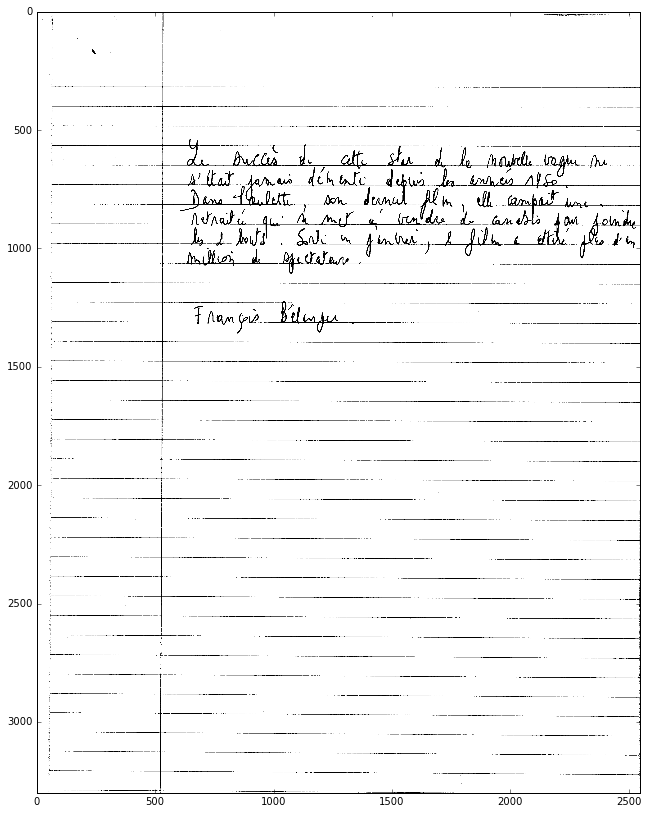

In [77]:
hdf5ims = h5py.File('/fileserver/nmec-handwriting/nmec_scaled_flat.hdf5')
origim = hdf5ims['FR-012-007.tif'].value
origim = hdf5ims[hdf5ims.keys()[6]].value

immin = origim.min()
immax = origim.max()
imthresh = 0.80*(immax - immin)+immin
print 'threshold = '+str(imthresh)

# Technically, this is what we need (0/1). But, since we're converting everything all the time, let's convert back to images
im = origim < imthresh

# Dumb part:
im = (1-im)*255

plt.figure(figsize=(14,14))
plt.imshow(im,cmap='gray')

In [78]:
print "Begin data transfer to buffers on image "
input_buffer = []
for i in xrange(0, im.shape[0] - input_shape[2] + 1, input_shape[2] - topbot_overlap*2 ):
    for j in xrange(0, im.shape[1] - input_shape[3] + 1, input_shape[3] - topbot_overlap*2 ):
        input_buffer += [im[i:i+input_shape[2], j:j+input_shape[3]]]
predictbuffer = np.expand_dims(1.0-np.array(input_buffer)/255.0, 1)
output_buffer = model.predict(predictbuffer, verbose = 1)

Begin data transfer to buffers on image 
1240/1240 [==============================] - 3s     


In [ ]:
output_im = np.zeros(im.shape)
shapesize = (input_shape[2], input_shape[3])
k = 0
for i in xrange(0, im.shape[0] - input_shape[2] + 1, input_shape[2] - topbot_overlap*2):
    for j in xrange(0, im.shape[1] - input_shape[3] + 1, input_shape[3] - topbot_overlap*2):
        startx = i+topbot_overlap
        stopx = i+input_shape[2]-topbot_overlap
        starty = j+topbot_overlap
        stopy = j+input_shape[3]-topbot_overlap
        imfill = output_buffer[k].reshape(shapesize)
        imfill = imfill[topbot_overlap:(input_shape[2]-topbot_overlap),topbot_overlap:(input_shape[2]-topbot_overlap)]
        output_im[startx:stopx, starty:stopy] = imfill
        k+=1
        
output_im = output_im > 0.5
plt.figure(figsize=(14,14))
plt.imshow(1-output_im, cmap='gray')